In [2]:
import numpy as np
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import os
import importlib
importlib.reload(pyuvdata)
from IPython.display import Image
from newcal import caldata, calibration_wrappers, calibration_optimization


In [3]:
importlib.reload(caldata)
importlib.reload(calibration_wrappers)

<module 'newcal.calibration_wrappers' from '/home/rbyrne/newcal/newcal/calibration_wrappers.py'>

In [2]:
import plot_delay_spectra
importlib.reload(plot_delay_spectra)

<module 'plot_delay_spectra' from '/home/rbyrne/rlb_hera/plot_delay_spectra.py'>

In [3]:
data_orig = pyuvdata.UVData()
data_orig.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
# model = pyuvdata.UVData()
# model.read("/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.52096.sum.abs_calibrated.red_avg_model.uvfits")
data_abscal = pyuvdata.UVData()
data_abscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_abscal.uvfits"
)
data_dwabscal = pyuvdata.UVData()
data_dwabscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_dwabscal_recalibrated.uvfits"
)
# data.read("/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.16911.uvh5")

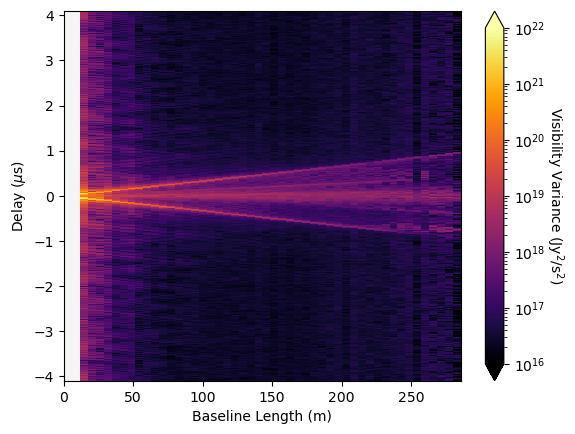

In [4]:
plot_delay_spectra.plot_visibilities(data_orig)

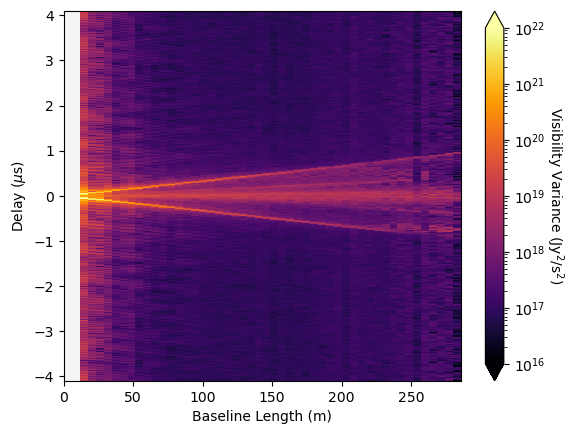

In [5]:
plot_delay_spectra.plot_visibilities(data_abscal)

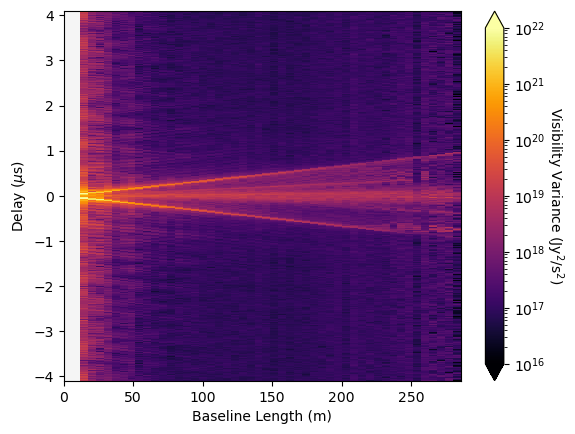

In [6]:
plot_delay_spectra.plot_visibilities(data_dwabscal)

In [7]:
# Normalize data
bl_bin_edges = np.linspace(0, 300, num=51)
delay_spectrum_dwabscal = plot_delay_spectra.calculate_delay_spectra(
    data_dwabscal, bl_bin_edges, use_polarization=-5
)
delay_spectrum_abscal = plot_delay_spectra.calculate_delay_spectra(
    data_abscal, bl_bin_edges, use_polarization=-5
)
data_dwabscal_normalized = data_dwabscal.copy()
print(np.nanmean(delay_spectrum_abscal))
print(np.nanmean(delay_spectrum_dwabscal))
data_dwabscal_normalized.data_array *= np.sqrt(np.nanmean(delay_spectrum_abscal) / np.nanmean(
    delay_spectrum_dwabscal
))

5.100236616496848e+18
5.097088146982287e+18


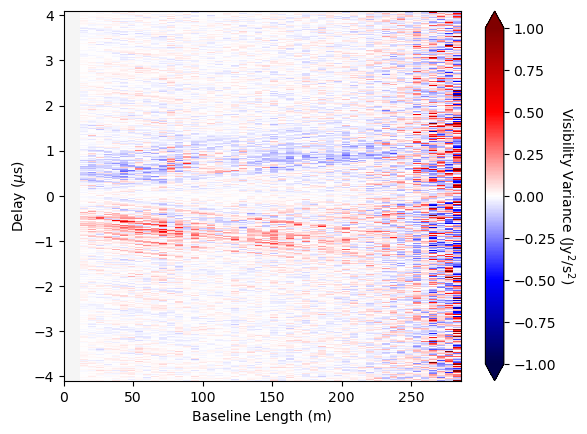

In [8]:
plot_delay_spectra.plot_difference(data_dwabscal, data_abscal, ratio=True)

In [9]:
dwabscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_dwabscal_params.npy"
)
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_abscal_params.npy"
)

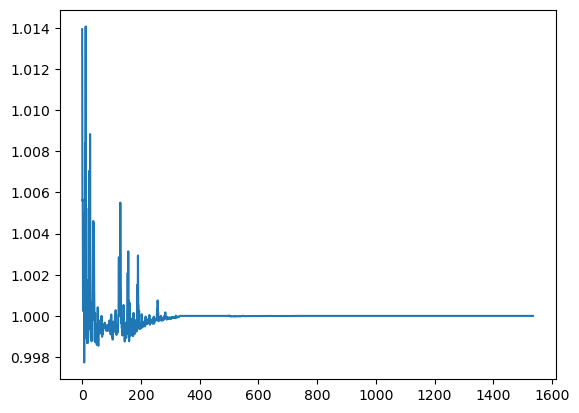

In [10]:
#plt.plot(abscal_params[1,:,0])
plt.plot(dwabscal_params[0, :, 0])
#plt.ylim([0,1.3])
plt.show()

In [11]:
use_cmap = matplotlib.cm.get_cmap("inferno")
use_cmap.set_bad(color="whitesmoke")
vmin = 1e16
vmax = 1e22
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
plt.imshow(
    avg_spectra["variance"].T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    aspect="auto",
)
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


NameError: name 'avg_spectra' is not defined

In [12]:
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal/zen.2459861.48181.sum.abs_calibrated.red_avg_abscal_params.npy"
)

In [13]:
np.shape(abscal_params)

(3, 1536, 2)

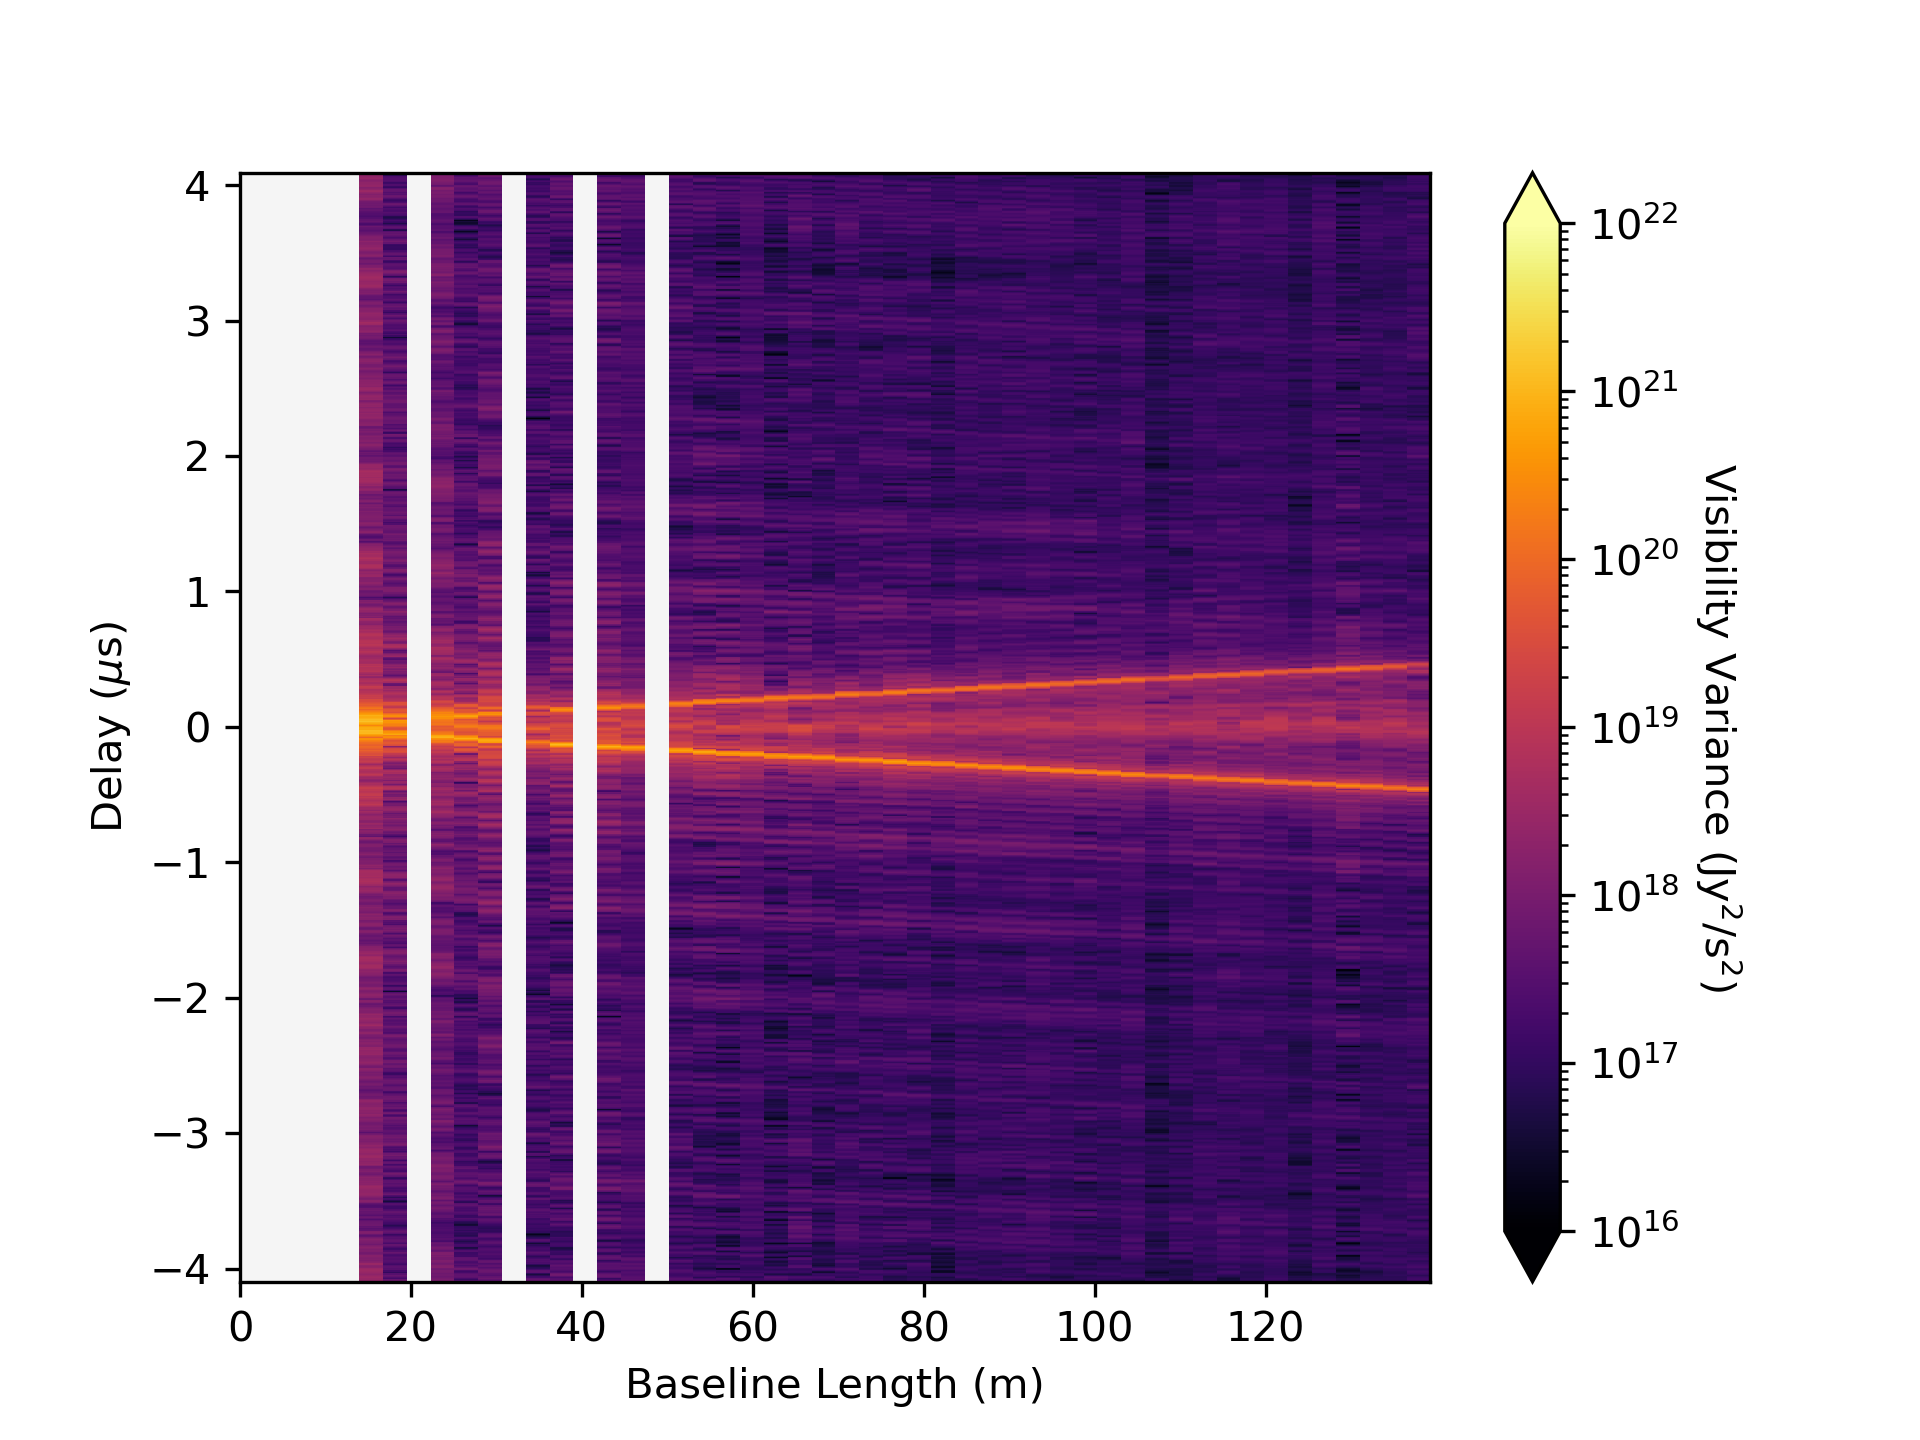

In [14]:
from IPython.display import Image
Image(
    filename="/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_diff.png"
)

In [15]:
cov_mat = np.load("/safepool/rbyrne/hera_abscal_Jun2024/dwcal_cov_matrix.npy")

In [16]:
np.shape(cov_mat)

(2, 417, 1536, 1536, 1)

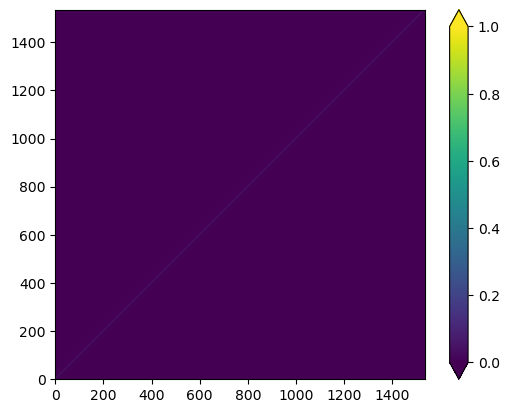

In [20]:
plt.imshow(np.abs(cov_mat[0,1,:,:,0]), interpolation=None, origin="lower", vmin=0, vmax=1)
cbar = plt.colorbar(extend="both")

In [18]:
np.where(np.abs(cov_mat) == np.max(np.abs(cov_mat)))

(array([0, 0, 0, ..., 1, 1, 1]),
 array([ 17,  17,  17, ..., 342, 342, 342]),
 array([   0,    1,    2, ..., 1533, 1534, 1535]),
 array([   0,    1,    2, ..., 1533, 1534, 1535]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [30]:
np.max(np.abs(cov_mat - np.conj(np.transpose(cov_mat, axes=(0,1,3,2,4)))))

0.0

In [4]:
data_path = f"/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
model_path = f"/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
data = pyuvdata.UVData()
data.read(data_path)
model = pyuvdata.UVData()
model.read(model_path)

data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

# Model does not include all baselines
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
use_polarizations = [
    pol for pol in model.polarization_array if pol in data.polarization_array
]
data.select(bls=use_baselines, polarizations=use_polarizations)
model.select(bls=use_baselines, polarizations=use_polarizations)

# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

data.compress_by_redundancy()
model.compress_by_redundancy()

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [5]:
caldata_obj = caldata.CalData()
caldata_obj.load_data(
    data,
    model,
)

divide by zero encountered in divide


In [6]:
avg_spectra = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/mean_variance_abscal_nbins200_xx.npz"
)
delay_spectrum_variance = avg_spectra["variance"]
bl_length_bin_edges = avg_spectra["bl_bin_edges"]
delay_axis = avg_spectra["delay_array"]

calibration_wrappers.get_dwcal_weights_from_delay_spectra(
    caldata_obj,
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
)

In [9]:
np.shape(caldata_obj.dwcal_inv_covariance)

(2, 417, 1536, 1536, 2)

In [10]:
np.mean(np.diagonal(caldata_obj.dwcal_inv_covariance[0,:,:,:,0],axis1=1,axis2=2))

(1.0071513021687715+0j)

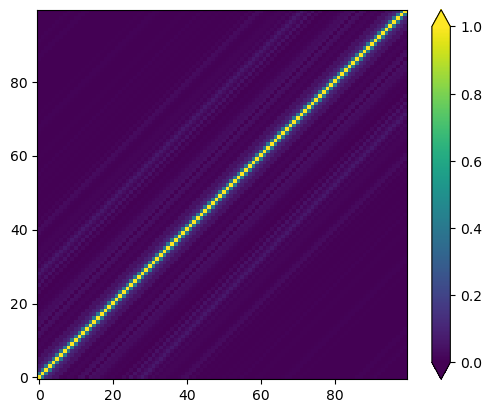

In [20]:
plt.imshow(
    np.abs(caldata_obj.dwcal_inv_covariance[0, 5, 0:100, 0:100, 0]), interpolation=None, origin="lower", vmin=0, vmax=1
)
cbar = plt.colorbar(extend="both")

In [19]:
for ind in range(417):
    print(np.max(np.abs(caldata_obj.dwcal_inv_covariance[0, ind, :, :, 0])))

0.02635876085843277
0.18254090734093378
0.3991952059800675
0.6405844260681602
0.8598806554242951
1.1614674324935723
1.3065518781664751
1.6408320498038527
1.686652879617542
0.02635876085843277
0.09849830449999845
0.30035890915939223
0.4702628121010756
0.7334422093265069
1.2238444163201125
1.5541269139498934
1.22870323020314
1.9039505490643192
1.7400446956811773
0.09849830449999845
0.18254090734093378
0.30035890915939223
0.3491494281574913
0.5427441074169324
0.7647309237592178
0.8235903159821993
1.05574003281454
1.1995361173968313
1.340951681480218
0.30035890915939223
0.3991952059800675
0.4702628121010756
0.5427441074169324
0.5717025004236814
0.8010055246657015
1.3065518781664751
1.2268872400430102
1.2798493939202937
0.7334422093265069
0.7647309237592178
0.8010055246657015
0.8296074512016377
0.9197913114612777
1.2568685105703425
0.5427441074169324
0.7334422093265069
0.8598806554242951
1.2238444163201125
0.8235903159821993
1.3065518781664751
0.9197913114612777
0.7543528892505472
1.5541269